The notebook is used to visualize the performance of PCE

In [1]:
# import packages
import pandas as pd
import numpy as np
import pickle
from veneer.pest_runtime import *
from veneer.manage import start,kill_all_now
import os

from funcs.read_data import variables_prep, file_settings
from funcs.modeling_funcs import vs_settings, \
        modeling_settings, paralell_vs, obtain_initials, change_param_values
from funcs.utils import timeseries_sum, update_bounds

In [3]:
# define the function for adaptive pce
vs_list = []
from gp_pce_model import *

## import samples and results for pce-sse

In [29]:
import pickle
gp_load = pickle.load(open(f'{file_settings()[0]}/run_0813/gp_0.pkl', "rb")) #-level4

In [7]:
# import observation if the output.txt requires the use of obs.
date_range = pd.to_datetime(['2009/07/01', '2018/06/30'])
observed_din = pd.read_csv(f'{file_settings()[1]}126001A.csv', index_col='Date')
observed_din.index = pd.to_datetime(observed_din.index)
observed_din = observed_din.loc[date_range[0]:date_range[1], :].filter(items=[observed_din.columns[0]]).apply(lambda x: 1000 * x)

In [8]:
# import the validation set
vali_samples = pd.read_csv(f'{file_settings()[1]}samples.csv', index_col='real_name')
vali_values = pd.read_csv(f'{file_settings()[1]}DIN_126001A.csv', index_col = 'Unnamed: 0')
vali_values.index = pd.to_datetime(vali_values.index)

In [28]:
# calculate the summed squared residuals of annual loads
import spotpy
def viney_F(evaluation, simulation):
    pb = sp.objectivefunctions.pbias(evaluation, simulation) / 100
    nse = sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
    F = nse - 5 *( np.abs(np.log(1 + pb)))**2.5
    return F

vali_annual = timeseries_sum(vali_values, temp_scale = 'annual')
obs_din = timeseries_sum(observed_din, temp_scale = 'annual')
obs_din = pd.DataFrame(obs_din, dtype='float')
din_126001A = pd.DataFrame(vali_annual, dtype='float')
model_vals = [viney_F(obs_din.values.flatten(), din_126001A.values[:, i]) for i in range(din_126001A.shape[1])]

In [32]:
# calculate the outputs of pce
pce_vals = gp_load.predict(vali_samples.values)

# extract the training samples
# train_samples = pce_load.variable_transformation.map_from_canonical_space(pce_load.samples)
# train_vals = pce_load.values

In [8]:
train_vals.shape

(155,)

## Scatter plot of validation samples

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rc
import latex
rc("text", usetex=False)
import seaborn as sns
from sklearn import metrics

In [41]:
# calculate the error 
r2 = metrics.r2_score(model_vals[0:1000], pce_vals.flatten()[0:1000])

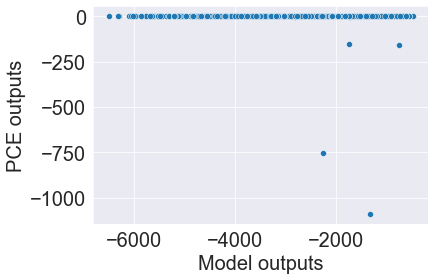

In [45]:
sns.set_style('darkgrid')
ax = sns.scatterplot(x = model_vals[0:1000], y = pce_vals.flatten()[0:1000]);
# ax.scatter(x = train_vals, y = train_vals, color='orange', alpha=0.7, s=20)
ax.set_xlabel('Model outputs')
ax.set_ylabel('PCE outputs')
# ax.text(x=1e5, y=1.8e6, s=f'R2: {np.round(r2, 2)}');
# Add a 1-1 line
# x_line = np.linspace(0, 2e6, 10000)
y_line = x_line
# sns.lineplot(x = x_line, y = y_line, color='k', ax=ax, linestyle='--', alpha=0.4)
# plt.savefig(f'{file_settings()[0]}figs/PCE_{year}_rmse_iter{num_iter}.png', format='png', dpi=300)

## Plot the residuals between the surrogate and the model

In [13]:
# calculate the residuals
resid = pce_vals.flatten() - model_vals.flatten()
bounds = [np.quantile(resid, 0.025), np.quantile(resid, 0.975)]
bounds

[-3275.5718104340253, 2933.375575691903]

In [15]:
# update the uncertainty bounds
f_name = f'{file_settings()[0]}adaptive/rmse_bounds.pkl'
bounds_dict = update_bounds(f_name, bounds)

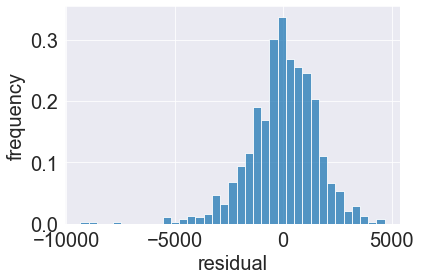

In [16]:
# plot the distribution of residuals
ax = sns.histplot(resid, stat='frequency');
ax.set_xlabel('residual')
ax.set_ylabel('frequency');
plt.savefig(f'{file_settings()[0]}figs/residual_rmse_iter{num_iter}.png', format='png', dpi=300)